In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
import seaborn as sns
from scipy.stats import spearmanr
import xgboost as xgb
from xgboost import XGBClassifier, to_graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Data Wrangling and feature Engineering

In [ ]:
df = pd.read_csv("./2025/AUG/GFDLCM_STOCK_01082025.csv").set_index("Time")
df.head()

,Ticker,Date,Open,High,Low,Close,Volume,Open Interest
Time,,,,,,,,
09:15:59,RELIANCE.NSE,01/08/2025,1386.9,1390.2,1384.3,1387.9,253531,0
09:16:59,RELIANCE.NSE,01/08/2025,1387.4,1390.1,1387.4,1388.4,43903,0
09:17:59,RELIANCE.NSE,01/08/2025,1388.4,1390.2,1386.6,1389.0,48738,0
09:18:59,RELIANCE.NSE,01/08/2025,1388.7,1390.0,1387.3,1388.9,66726,0
09:19:59,RELIANCE.NSE,01/08/2025,1389.4,1392.0,1389.2,1390.8,30723,0


In [ ]:
drop_columns = ["Ticker", "Date", "Volume", "Open Interest"]
df = df.drop(columns=drop_columns)

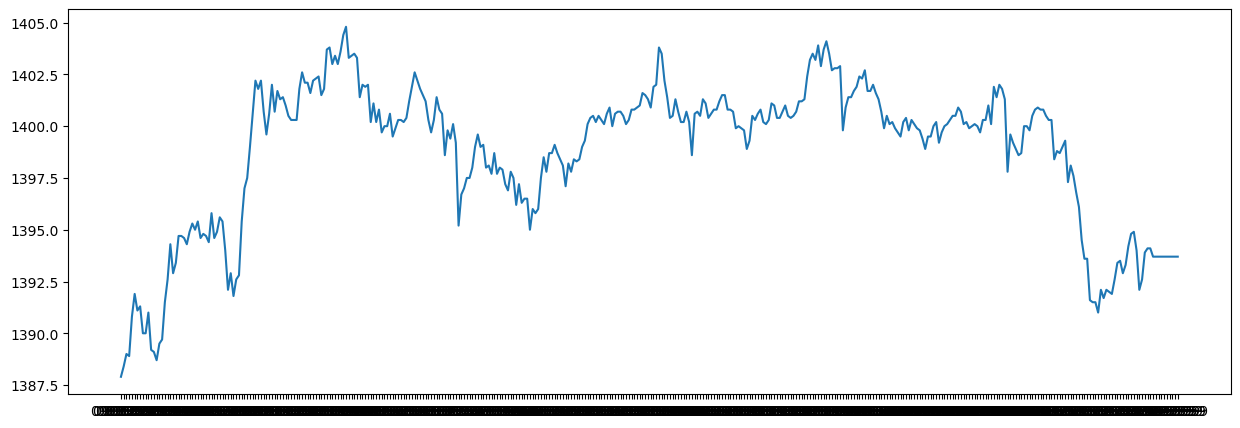

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["Close"])

In [ ]:
df["co"] = df["Close"] - df["Open"]
df["ch"] = df["Close"] - df["High"]
df["cl"] = df["Close"] - df["Low"]

In [ ]:
drop_columns = ["Open", "High", "Low"]
df = df.drop(columns=drop_columns)

In [ ]:
df.corr()

,Close,co,ch,cl
Close,1.000000,0.055135,0.222217,-0.111354
co,0.055135,1.000000,0.712259,0.631959
ch,0.222217,0.712259,1.000000,0.195782
cl,-0.111354,0.631959,0.195782,1.000000


<Axes: >

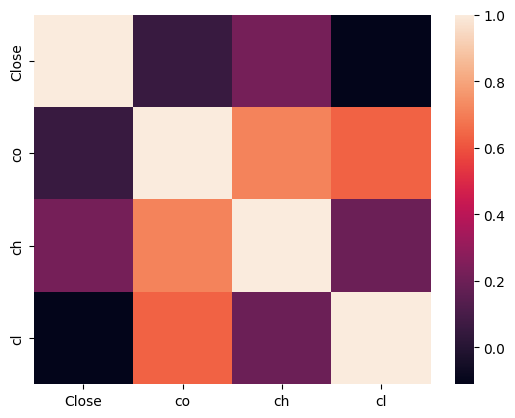

In [ ]:
sns.heatmap(df.corr())

In [ ]:
df["Return_15min"] = df["Close"].pct_change(periods=15) * 100
df["Return_15min"] = df["Return_15min"].shift(-15)
df = df.drop(columns=["Close"])

In [ ]:
print(df.isna().sum())

co               0
ch               0
cl               0
Return_15min    15
dtype: int64


In [ ]:
df = df.dropna(how='any')
print(df.isna().sum())

co              0
ch              0
cl              0
Return_15min    0
dtype: int64


<Axes: >

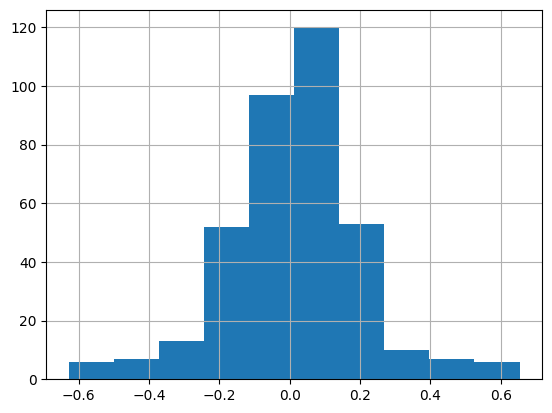

In [ ]:
df["Return_15min"].hist()

In [ ]:
df = df.copy()

In [ ]:
# df.loc[:, "target"] = 0
# df.loc[df["Return_15min"] > 0.35, "target"] = 1
# df.loc[df["Return_15min"] < -0.35, "target"] = -1
# df = df.drop(columns=["Return_15min"])

In [ ]:
df.loc[:, "target"] = 0
df.loc[df["Return_15min"] > 0.06, "target"] = 1
df.loc[df["Return_15min"] < -0.05, "target"] = 2
df = df.drop(columns=["Return_15min"])

In [ ]:
print(df["target"].value_counts())

target
1    138
2    129
0    104
Name: count, dtype: int64


In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [ ]:
print(X.head())

           co   ch   cl
Time                   
09:15:59  1.0 -2.3  3.6
09:16:59  1.0 -1.7  1.0
09:17:59  0.6 -1.2  2.4
09:18:59  0.2 -1.1  1.6
09:19:59  1.4 -1.2  1.6


In [ ]:
print(y.head())

Time
09:15:59    1
09:16:59    1
09:17:59    1
09:18:59    1
09:19:59    1
Name: target, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# majority_class, minority_class = y_test.value_counts(normalize=True)  # This gives us the value in terms of probabilities

In [ ]:
acc_baseline = y_test.value_counts(normalize=True).max() 
print("Baseline Accuracy: ", round(acc_baseline,2))

Baseline Accuracy:  0.37


#### Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

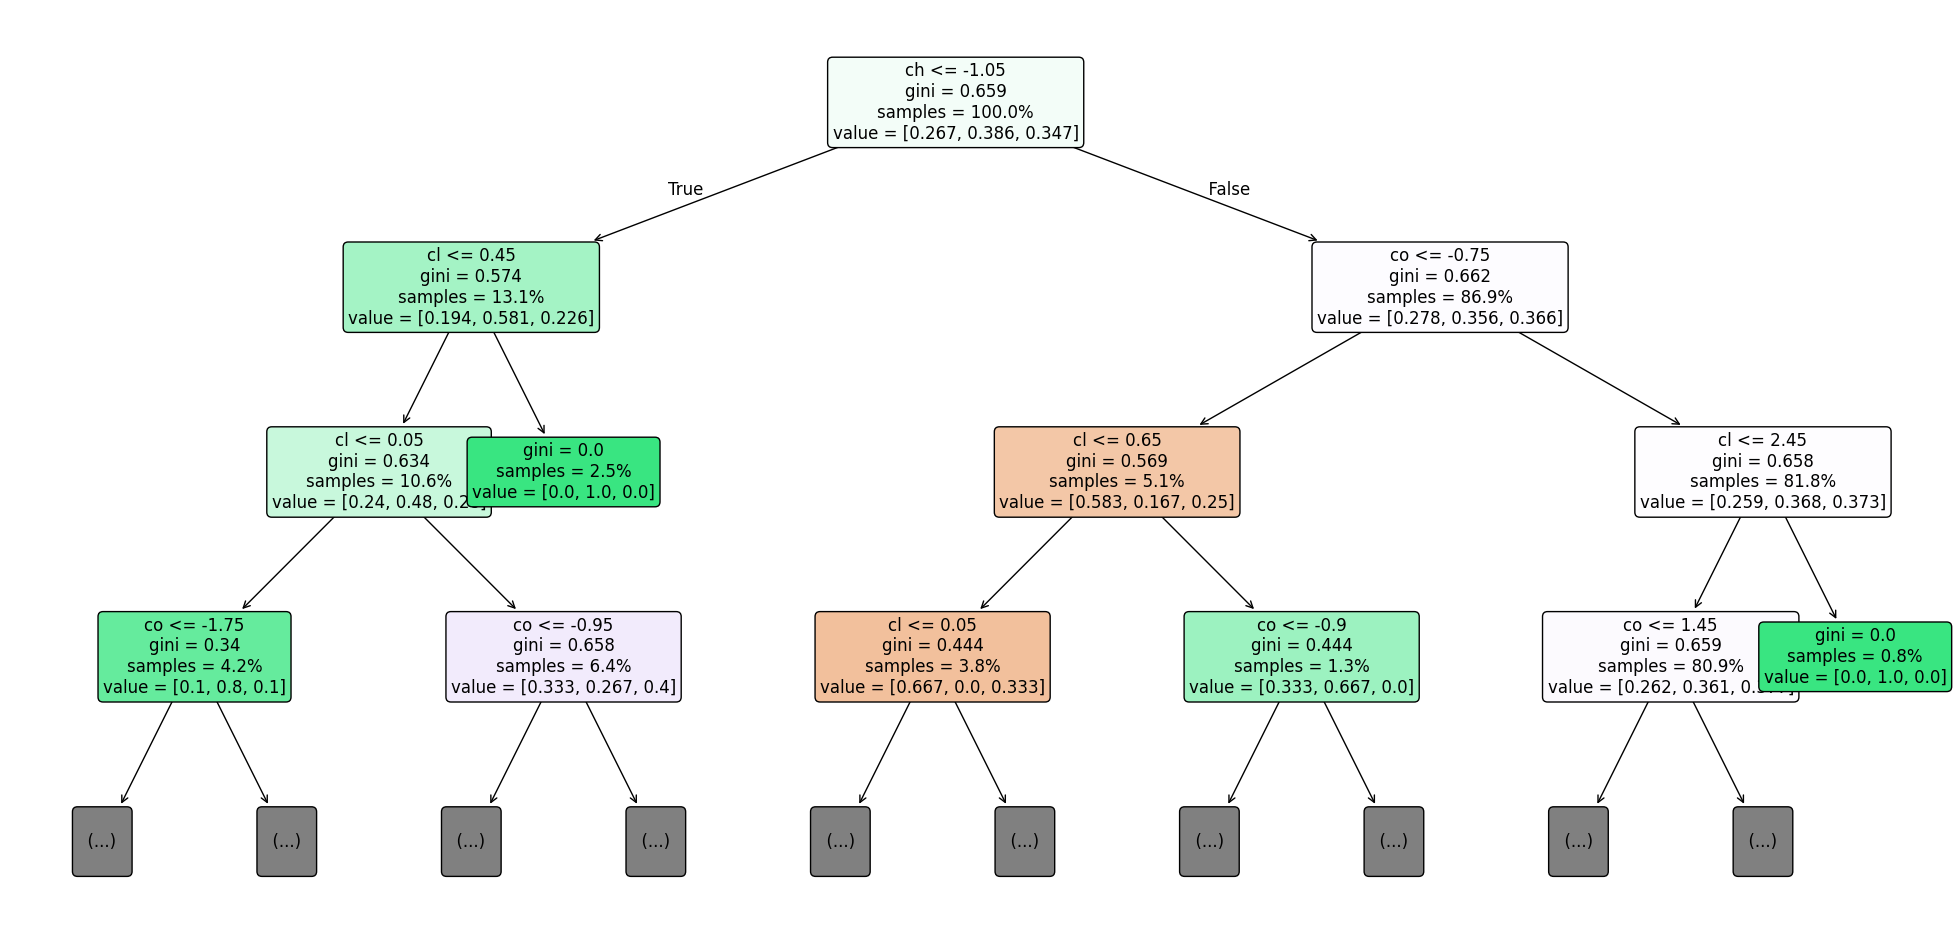

In [ ]:
fig, ax = plt.subplots(figsize=(25,12))
#Plot tree
plot_tree(
    dt,
    feature_names= X_train.columns,
    filled=True, #Color leaf with classes
    rounded=True, #Round leaf edges
    proportion=True, #Display proportion of classes in leaf
    max_depth=3, #Only display first three levels
    fontsize=12, #Enlarge Font
    ax=ax #Place in figure axis
);

    - Print complete Tree

In [ ]:
print("Base Accuracy:", accuracy_score(y_test, y_pred))

Base Accuracy: 0.30666666666666664


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 5  9  7]
 [ 8 13  7]
 [10 11  5]]


In [ ]:
acc_train = accuracy_score(y_train, dt.predict(X_train))
acc_val = accuracy_score(y_val, dt.predict(X_val))

In [ ]:
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.92
Validation Accuracy: 0.37


- Our model is overfitted

    - Hyperparameter Tuning

In [ ]:
depth_hyperparams = range(1,50,2)

In [ ]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.3940677966101695, 0.4322033898305085, 0.4915254237288136]
Validation Accuracy Scores: [0.38333333333333336, 0.4, 0.4166666666666667]


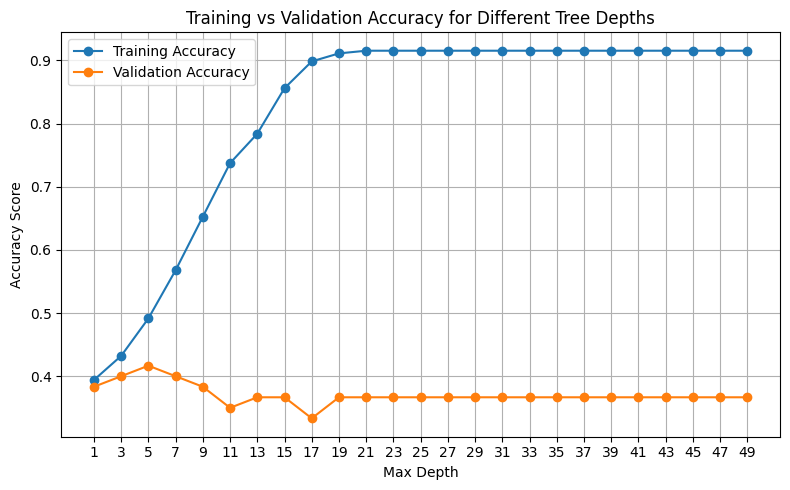

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
best_dt = DecisionTreeClassifier(
    max_depth=5,   
    random_state=42
)

In [ ]:
best_dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
y_pred = best_dt.predict(X_test)

    - Testing on test set

In [ ]:
acc_train = accuracy_score(y_train, best_dt.predict(X_train))
acc_val = accuracy_score(y_val, best_dt.predict(X_val))
acc_test = accuracy_score(y_test, best_dt.predict(X_test))

In [ ]:
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))
print("Testing Accuracy:", round(acc_test, 2))

Training Accuracy: 0.49
Validation Accuracy: 0.42
Testing Accuracy: 0.41


    - Confusion Matrix is considered a better metrics for classification problems

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[ 1  3 17]
 [ 1 11 16]
 [ 2  5 19]]


[[ 1  3 17]
 [ 1 11 16]
 [ 2  5 19]]


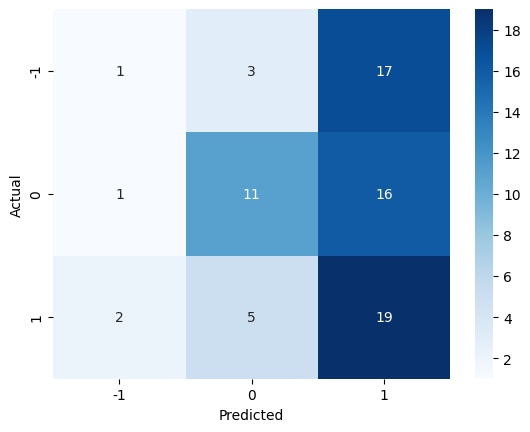

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[-1,0,1],
            yticklabels=[-1,0,1],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.24      0.27        21
           1       0.42      0.50      0.46        28
           2       0.38      0.38      0.38        26

    accuracy                           0.39        75
   macro avg       0.37      0.37      0.37        75
weighted avg       0.38      0.39      0.38        75

